# Geocodificação e geocodificação reversa
## Consumindo API Geolocalização opencagedata 

In [1]:
#Script para realizar a ocultação do codigo nas celulas
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
#Dependnecias do projeto
import yaml
import json
import requests
import os, sys
import matplotlib
import numpy as np


In [3]:
from matplotlib.patches import Circle, Wedge, Rectangle
from matplotlib import cm
from matplotlib import pyplot as plt
from opencage.geocoder import OpenCageGeocode
from pprint import pprint

In [4]:
#Realiza a carga do arquivo de configurações que possui a chave da API,não dispponivel no repositorio publico
'''Ex: 
key: API-key-S3cre#tA63'''

with open("/opt/config.yaml", "r") as s:
    y = yaml.load(s, Loader=yaml.Loader)

    

In [5]:
#Register API

key = y["key"]
geocoder = OpenCageGeocode(key)



### Ecemplo de saida de dados API

In [6]:
#-19.435657 -44.207715
#pretty = '1', no_annotations='1' Argumentos opcionais

results = geocoder.reverse_geocode(-19.435657, -44.207715,pretty = '1', no_annotations='1')
pprint(results)


[{'bounds': {'northeast': {'lat': -19.4347831, 'lng': -44.2071165},
             'southwest': {'lat': -19.4370706, 'lng': -44.2080792}},
  'components': {'ISO_3166-1_alpha-2': 'BR',
                 'ISO_3166-1_alpha-3': 'BRA',
                 '_category': 'road',
                 '_type': 'road',
                 'city': 'Sete Lagoas',
                 'continent': 'South America',
                 'country': 'Brazil',
                 'country_code': 'br',
                 'county': 'Microrregião Sete Lagoas',
                 'postcode': '35701-618',
                 'road': 'Rua Durval Moreira de Oliveira',
                 'road_type': 'residential',
                 'state': 'Minas Gerais',
                 'state_code': 'MG',
                 'state_district': 'Região Geográfica Intermediária de Belo '
                                   'Horizonte',
                 'suburb': 'Tamanduá'},
  'confidence': 9,
  'formatted': 'Rua Durval Moreira de Oliveira, Tamanduá, Sete Lagoas -

### Saída de dados de exemplo.

In [17]:
#dados da list
print(type(results))
print(results[0]['formatted'])
print(results[0]['geometry'])

<class 'list'>
Rua Durval Moreira de Oliveira, Tamanduá, Sete Lagoas - MG, 35701-618, Brazil
{'lat': -19.4356557, 'lng': -44.207712}


In [7]:
#rertorna a quantide desponivel de utilização da API 
response = requests.get("https://api.opencagedata.com/geocode/v1/json?key=80f57f9380ea40f3897eaf54857f8cd4")

result = json.loads(response.text)

print(result["rate"])

{'limit': 2500, 'remaining': 2498, 'reset': 1597968000}


In [8]:
#neste bloco onde é criado um indicador de consumo para  a API

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation


In [9]:
#desenho do plot de gauge

def gauge(labels=['LOW','MEDIUM','HIGH','VERY HIGH','EXTREME'], \
          colors='jet_r', arrow=1, title='', fname=False): 
    
    """
    some sanity checks first
    
    """
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

In [10]:
#condicional para a flecha 
result_arrow = (result["rate"]["limit"]) - (result["rate"]["remaining"])
def to_arrow():
    #result_arrow = 3550
    if result_arrow <= 500:
        return 1
    elif result_arrow <= 1000:
        return 2
    elif result_arrow <= 1500:
        return 3
    elif result_arrow <= 2000:
        return 4
    else:
        return 5

### Contador de chamadas  para a API OpenCage.

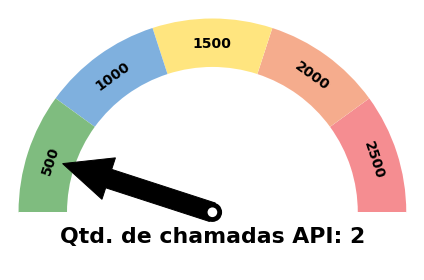

In [11]:
gauge(labels=['500','1000','1500','2000','2500'], \
      colors=['#007A00','#0063BF','#FFCC00','#ED5b1D','#ED1C24'], arrow= to_arrow(), title='Qtd. de chamadas API: ' + str(result_arrow) )